In [3]:
!pip -q install transformers

     |████████████████████████████████| 1.3MB 12.1MB/s 
     |████████████████████████████████| 1.1MB 55.1MB/s 
     |████████████████████████████████| 890kB 63.0MB/s 
     |████████████████████████████████| 2.9MB 62.2MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch

In [2]:
import numpy as np
import pandas as pd
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertModel
from torch.nn import CrossEntropyLoss
import re

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
print(dev)
dev = torch.device(dev) 

cuda:0


In [60]:
## Possible Tags
tag_vals = ['O', 'B-POS', 'B-NEU', 'B-NEG', 'B-CON', 'I-POS', 'I-NEU', 'I-NEG', 'I-CON', 'PAD']
idx = 0
tag_to_idx = {}
for i in tag_vals:
  tag_to_idx[i] = idx
  idx += 1

print(tag_to_idx)

## Data files
train_path = '/content/drive/MyDrive/sem5/NLP/dataset/rest/train.txt'
test_path = '/content/drive/MyDrive/sem5/NLP/dataset/rest/test.txt'

idx = 0

def get_data(path):
  f = open(path, 'r')
  data = []
  labels = []
  words = []
  m1 = -1
  for line in f:
    line = line.split('###')
    data.append(line[0])
    tags = []
    line[1] = line[1].split()
    m1 = max(m1,len(line[1]))
    w = []
    for word in line[1]:
      word = [word[:word.find('=')+1], word[len(word) - word[::-1].find('='):]]
      w.append(word[0])
      try:
        tags.append(tag_to_idx[word[1]])
      except:
        print(word)
    labels.append(tags)
    words.append(w)
  return data, labels, words

train_data, train_labels, w1 = get_data(train_path)
test_data, test_labels, w2 = get_data(test_path)

{'O': 0, 'B-POS': 1, 'B-NEU': 2, 'B-NEG': 3, 'B-CON': 4, 'I-POS': 5, 'I-NEU': 6, 'I-NEG': 7, 'I-CON': 8, 'PAD': 9}


# **Visualising The Data**

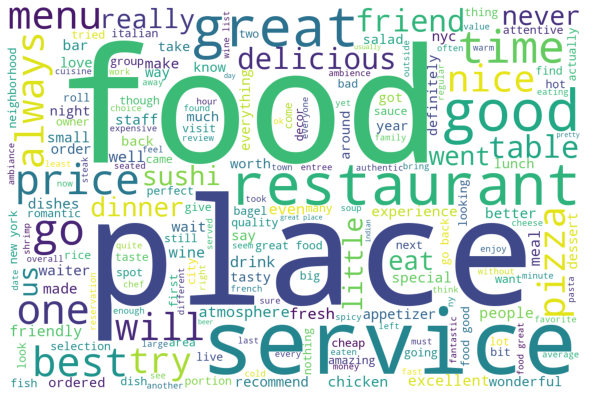

In [4]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
    
comment_words = '' 
stopwords = set(STOPWORDS) 

total_sentences = train_data + test_data
for sent in total_sentences: 
    sent = sent.lower()
    tokens = sent.split() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1200, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 1).generate(comment_words) 
  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [5]:
MAX_LEN = 100
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
lr = 1e-5
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
class dataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, words,max_len):
        self.len = len(sentences)
        self.sentences = sentences
        self.labels = labels
        self.words = words
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.sentences[index])
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        word = self.words[index]
        label = self.labels[index]
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        label.extend([9]*200)
        label=label[:MAX_LEN]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'tags': torch.tensor(label, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [7]:
train_sentences = train_data
test_sentences = test_data
training_set = dataset(tokenizer, train_sentences, train_labels, w1,MAX_LEN)
testing_set = dataset(tokenizer, test_sentences, test_labels, w2, MAX_LEN)

In [8]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [11]:
tag_vals = ['O', 'B-POS', 'B-NEU', 'B-NEG', 'B-CON', 'I-POS', 'I-NEU', 'I-NEG', 'I-CON', 'PAD']
labels_ = {}
for ex in train_labels:
  for t in ex:
    if tag_vals[t] in labels_:
      labels_[tag_vals[t]] += 1
    else:
      labels_[tag_vals[t]] = 1
print(labels_)
weights = [1/labels_['O'], 1/labels_['B-POS'], 1/labels_['B-NEU'], 1/labels_['B-NEG'], 1/labels_['B-CON'], 1/labels_['I-POS'], 1/labels_['I-NEU'], 1/labels_['I-NEG'], 1/labels_['I-CON'], 0.0001]

{'O': 41963, 'B-NEG': 807, 'B-POS': 2155, 'B-NEU': 638, 'I-POS': 971, 'I-NEU': 238, 'B-CON': 89, 'I-NEG': 207, 'I-CON': 24}


In [12]:
class BERT_with_self_attention(torch.nn.Module):
    def __init__(self, num_labels):
        super(BERT_with_self_attention, self).__init__()
        self.num_labels = num_labels
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.1)
        self.multihead_attn = torch.nn.MultiheadAttention(768, 8)
        self.q = torch.nn.Linear(768, 768)
        self.k = torch.nn.Linear(768, 768)
        self.v = torch.nn.Linear(768, 768)
        self.classifier = torch.nn.Linear(768, self.num_labels)
        self.act = torch.nn.ReLU()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        query = self.q(sequence_output)
        query = self.act(query)
        
        key = self.k(sequence_output)
        key = self.act(key)

        value = self.v(sequence_output)
        value = self.act(value)

        attn_output, attn_output_weights = self.multihead_attn(query, key, value)        
        logits = self.classifier(attn_output)

        loss = None
        global class_weights
        if labels is not None:
            class_weights = torch.FloatTensor(weights).cuda()
            loss_fct = CrossEntropyLoss(weight=class_weights)
            loss_fct = CrossEntropyLoss()

            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        output = (logits,) + outputs[2:]
        return ((loss,) + output) if loss is not None else output

In [13]:
model = BERT_with_self_attention(10)
model.to(dev)

BERT_with_self_attention(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [14]:
lr = 3e-5
optimizer = transformers.AdamW(params =  model.parameters(), lr=lr)

In [15]:
lo = {}
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(dev, dtype = torch.long)
        mask = data['mask'].to(dev, dtype = torch.long)
        targets = data['tags'].to(dev, dtype = torch.long)
        loss = model(ids, mask, labels = targets)[0]
        if _%500==0:
            lo[epoch] = loss.item()
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [16]:
EPOCHS = 20
for epoch in range(EPOCHS):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  2.3089282512664795
Epoch: 1, Loss:  0.6146529912948608
Epoch: 2, Loss:  0.4558413624763489
Epoch: 3, Loss:  0.459171861410141
Epoch: 4, Loss:  0.40355509519577026
Epoch: 5, Loss:  0.3978578746318817
Epoch: 6, Loss:  0.3469525873661041
Epoch: 7, Loss:  0.257049024105072
Epoch: 8, Loss:  0.25975140929222107
Epoch: 9, Loss:  0.23357094824314117
Epoch: 10, Loss:  0.24022339284420013
Epoch: 11, Loss:  0.17800909280776978
Epoch: 12, Loss:  0.14860177040100098
Epoch: 13, Loss:  0.14003288745880127
Epoch: 14, Loss:  0.1493409425020218
Epoch: 15, Loss:  0.11996106058359146
Epoch: 16, Loss:  0.14594149589538574
Epoch: 17, Loss:  0.10809536278247833
Epoch: 18, Loss:  0.08625396341085434
Epoch: 19, Loss:  0.0843813419342041


## **Training Summary**

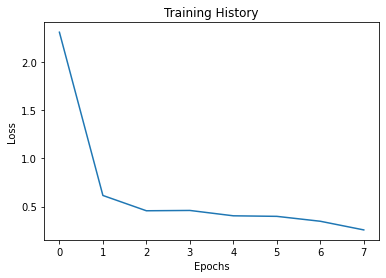

In [17]:
ep = [i for i in range(8)]
loss = []
for i in range(8):
  loss.append(lo[i])

plt.plot(ep, loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training History')
plt.show()

## **Performance On test Set**

In [18]:
def valid(model, testing_loader):
    model.eval()
    eval_loss = 0; eval_accuracy = 0
    n_correct = 0; n_wrong = 0; total = 0
    predictions , true_labels = [], []
    nb_eval_steps, nb_eval_examples = 0, 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(dev, dtype = torch.long)
            mask = data['mask'].to(dev, dtype = torch.long)
            targets = data['tags'].to(dev, dtype = torch.long)

            output = model(ids, mask, labels=targets)
            loss, logits = output[:2]
            logits = logits.detach().cpu().numpy()
            label_ids = targets.to('cpu').numpy()
            predictions.append([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.append(label_ids)
            eval_loss += loss.mean().item()
            nb_eval_examples += ids.size(0)
            nb_eval_steps += 1
        eval_loss = eval_loss/nb_eval_steps
        return predictions, true_labels

In [19]:
# To get the results on the test set. This data is not seen by the model
p,t = valid(model, testing_loader)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [20]:
y_true = []
y_pred = []
for batch in range(len(t)):
  for entry in range(len(t[batch])):
    N = 0
    while t[batch][entry][N] != 9 and N<len(p[batch][entry]) and N<len(t[batch][entry]):
      N+=1 
    try:
      a = [tag_vals[p[batch][entry][i]] for i in range(N)]
      y_pred.append(a)
      b = [tag_vals[t[batch][entry][i]] for i in range(N)]
      y_true.append(b)
    except:
      print("Error")

for i in range(len(y_pred)):
  for j in range(len(y_pred[i])):
    if y_pred[i][j] == 'PAD':
      y_pred[i][j] = 'O'
    if y_true[i][j] == 'PAD':
      print(y_true[i])
      break

from sklearn import metrics
yp = [tag for sent in y_pred for tag in sent]
yt = [tag for sent in y_true for tag in sent]

# **Evaluation Metrics**

In [21]:
print(metrics.classification_report(yt, yp))

              precision    recall  f1-score   support

       B-CON       0.00      0.00      0.00        15
       B-NEG       0.61      0.14      0.23       194
       B-NEU       0.44      0.14      0.22       196
       B-POS       0.59      0.65      0.62       730
       I-NEG       0.17      0.06      0.08        53
       I-NEU       0.50      0.05      0.10       113
       I-POS       0.59      0.45      0.51       355
           O       0.95      0.99      0.97     10967

    accuracy                           0.91     12623
   macro avg       0.48      0.31      0.34     12623
weighted avg       0.90      0.91      0.90     12623



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix

In [22]:
confusion_matrix = pd.DataFrame(metrics.confusion_matrix(yt, yp))
confusion_matrix.columns = ['B-CON', 'B-NEG', 'B-NEU', 'B-POS', 'I-NEG', 'I-NEU', 'I-POS', 'O']
confusion_matrix.index = ['B-CON', 'B-NEG', 'B-NEU', 'B-POS', 'I-NEG', 'I-NEU', 'I-POS', 'O']
print(confusion_matrix)

       B-CON  B-NEG  B-NEU  B-POS  I-NEG  I-NEU  I-POS      O
B-CON      0      0      0     14      0      0      0      1
B-NEG      0     28     20     86      0      0      1     59
B-NEU      0      6     28     78      3      2      2     77
B-POS      0      7      6    478      0      0     22    217
I-NEG      0      0      1      4      3      0     20     25
I-NEU      0      0      1      9      6      6     38     53
I-POS      0      0      0     32      5      1    161    156
O          0      5      8    108      1      3     29  10813


In [23]:
PATH = '/content/drive/MyDrive/sem5/NLP/absa_rest_self_attn.sav'
## Save
torch.save(model.state_dict(), PATH)
## Load

# model = BERT(5)
# model.to(dev)
# model.load_state_dict(torch.load(PATH))

## **TEST WITH YOUR SENTENCES**

In [57]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize


sent = {'NEG':'Negative', 'POS': 'Positive', 'NEU':'Neutral'}
tag_vals = ['O', 'B-POS', 'B-NEU', 'B-NEG', 'B-CON', 'I-POS', 'I-NEU', 'I-NEG', 'I-CON', 'PAD']

idx = 0
sentence = 'Please do not try the chicken, it is terrible'

sentence = sentence.lower()
inputs = tokenizer(sentence, return_tensors="pt", max_length= 100 ,padding='max_length')
id = inputs['input_ids'].to(dev)
ret = tokenizer.decode(id[0])
att = inputs['attention_mask'].to(dev)
output = model(id, att)
logits = output[0]
logits = logits.detach().cpu().numpy()
a = [list(p) for p in np.argmax(logits, axis=2)]
out = a[0]
out = [tag_vals[i] for i in out]

asp = []
inpu = word_tokenize(sentence)
out = out[:len(inpu)]
i = 0
while i< len(out):
  if out[i] != 'O' and out[i] !='PAD':
    j = i
    aspect_term = [inpu[j]]
    j+=1
    while j<len(out) and out[j] == 'I-'+out[i][2:]:
      aspect_term.append(inpu[j]) 
      j+=1
    aspect_term = ' '.join(aspect_term)
    asp.append((aspect_term,out[i][2:]))
    i = j
  else:
    i+=1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [58]:
print('Input Sentence:',sentence)
if len(asp) == 0:
  print("No Aspect Terms")
else:
  for entry in asp:
    print('Aspect Term: {}, Sentiment: {}'.format(entry[0], sent[entry[1]]))

Input Sentence: please do not try the chicken, it is terrible
Aspect Term: chicken, Sentiment: Positive


In [59]:
print(*inpu, sep = '\t')
print()
print(*out, sep = '\t')
print()

please	do	not	try	the	chicken	,	it	is	terrible

O	O	O	O	O	B-POS	O	O	O	O

